# Airbnb Project

## Import Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import operator
from math import hypot
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

## Data Cleaning

#### Data Cleaning formulas we will use


In [2]:
properties = ['Apartment', 'House', 'Condomminium', 'Townhouse', 'Loft', 'Other']
def property_grouping(p):
    '''
    Given property type, if it is not an apartment, house, condo, townhouse, loft, or
    labeled as 'Other', set as 'Other'
    '''
    if p not in properties:
        p = 'Other'
    return p

def make_dummies(df):
    '''
    Take column of categories and make dummies in the dataset.
    Drop the original columns
    '''
    columns = list(df.columns)
    for column in columns:
        dummies = pd.get_dummies(df[column])
        df = df.join(dummies)
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('/','_')
    df.columns = df.columns.str.replace('-', '_')
    df.drop(columns=columns,inplace=True)
    return df

#### Calculating Distance
There are 6 cities in the dataset. We are setting the coordinates for the downtown of each city.
Then we calculate the distance of each Airbnb from downtown.

In [3]:
lat_long = {'SF': {'lat': 37.7749, 'long': -122.4194},
            'Chicago': {'lat': 41.8781, 'long': -87.6298},
            'DC': {'lat': 38.9072, 'long': -77.0369},
            'LA': {'lat': 34.0522, 'long': -118.2437},
            'Boston': {'lat': 42.3601, 'long': -71.0589},
            'NYC': {'lat': 40.7128, 'long': -74.0060}}

def get_distance(row):
    '''
    Given a row of data, get the city, latitude, and longitude
    and calculate the distance from downtown.
    '''
    city = row['city']
    lat1 = lat_long[city]['lat']
    lat2 = row['latitude']
    long1 = lat_long[city]['long']
    long2 = row['longitude']
    lon = long1 - long2
    lat = lat1 - lat2
    a = (np.sin(lat/2))**2 + np.cos(lat1) * np.cos(lat2) * ((np.sin(lon/2))**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return 69.172*c

#### Cleaning up

In [4]:
#import data as dataframe
df = pd.read_csv('train.csv')
#Came back and separated Chicago
chi_df = df[df['city']=='Chicago']

In [5]:
#drop duplicates for Airbnb ID's and drop NA in specific columns
df.drop_duplicates(subset=['id'],inplace=True)
df.dropna(subset=['bathrooms', 'host_has_profile_pic',
                  'host_identity_verified', 'host_since',
                  'bedrooms', 'beds'],
                   inplace=True)

#create our distance column
df['distance'] = df.apply(lambda r: get_distance(r), axis=1)

#convert host response rates and review scores to floats between 0 and 1
df['host_response_rate'] = df['host_response_rate'].str.strip('%').astype('float')/100
df.review_scores_rating = df.review_scores_rating/100

#fill in empty host response rates and review scores as 0
df['host_response_rate'].fillna(value=0.0, inplace=True)
df['review_scores_rating'].fillna(value=0.0, inplace=True)

#Replace t,f and True,False to 1 and 0
df.replace({'t':1, 'f': 0}, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype(int)

#Apply a sqrt transform on number_of_reviews
df.number_of_reviews = df.number_of_reviews.apply(lambda x: np.sqrt(x))

Create new feature where we find the ratio of people per room for each listing.

In [6]:
#make a new columns of accommodates per bedroom
df['ppl_per_room'] = df['accommodates'] / df['bedrooms']

#replace inf and -inf with 0.0
df.ppl_per_room = df.ppl_per_room.replace([np.inf, -np.inf], float(0.0))

Dropping categories we do not want.

In [7]:
df_cleaned = df.drop(columns = ['id','amenities', 'description',
                               'first_review', 'host_since', 'last_review',
                               'name', 'neighbourhood', 'thumbnail_url',
                               'zipcode', 'city', 'latitude', 'longitude', 'beds'])

Working on the property_type category.

In [8]:
#apply property_grouping function to property_type
df_cleaned['property_type'] = df_cleaned['property_type'].apply(property_grouping)

#get rid of any super strict policies since there are relatively a few of them
df_cleaned = df_cleaned[df_cleaned['cancellation_policy'].str.contains('super')==False]

Rearranging our dataframe to our liking.

In [9]:
B = df_cleaned.select_dtypes(exclude='object')
A = df_cleaned[['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified','instant_bookable']]
B = B.drop(columns=list(A.columns))
C = df_cleaned.select_dtypes(include='object')

The cleaned and rearranged dataframe we wil work with from now on.

In [10]:
final_df = A.join(C)
final_df = final_df.join(B)

Some encoding on property type, room type, bed type, and cancellation policy since they are all categorical.

In [11]:
dummies = make_dummies(final_df.iloc[:,4:8])
final_df = final_df.join(dummies)
final_df.drop(columns=['property_type', 'room_type', 'bed_type', 'cancellation_policy'], inplace=True)

Setting our independent variable separate from our dependent variables.

In [12]:
y = final_df.log_price
final_df.drop(columns='log_price',inplace=True)

I will run a train-test split on the data to make sure our model does well on data it hasn't seen before.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=.3)

# Analysis

## Run our model on our train data

We are setting our categorical and numeric data separately. Our extra is composed of columns with binary values.

In [14]:
X_numeric_train = X_train.iloc[:,4:12]
X_categorical_train = X_train.iloc[:,12:]
X_extra_train = X_train.iloc[:,:4]

Scaling our data for a more direct compmarison and maintain our columns and index values

In [15]:
ss = StandardScaler()

X_num_train_col = X_numeric_train.columns
X_num_train_ind = X_numeric_train.index

X_numeric_train = pd.DataFrame(ss.fit_transform(X_numeric_train))

X_numeric_train.columns = X_num_train_col
X_numeric_train.index = X_num_train_ind

Drop our outliers and make sure the indices are the same over all the dataframes

In [16]:
X_numeric_train = X_numeric_train[(np.abs(X_numeric_train) < 2.5).all(axis=1)]

X_categorical_train = X_categorical_train[X_categorical_train.index.isin(X_numeric_train.index)]
X_extra_train = X_extra_train[X_extra_train.index.isin(X_numeric_train.index)]
y_train = y_train[y_train.index.isin(X_numeric_train.index)]

Put our entire dataframe back together.

In [17]:
X1 = X_numeric_train.join(X_categorical_train)
X1 = X1.join(X_extra_train)

### Baseline
Getting rid of the dummy trap by setting our baseline as having an entire Apartment with a real bed and moderate rule policies. Then we see what our score is.

In [18]:
X1.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)
lr_train = LinearRegression()
lr_train.fit(X1,y_train)
lr_train.score(X1,y_train)

0.5010128380309874

# Test Data

Rerun our model on our test data. We only changed variables from *train* to *test*.

In [19]:
X_numeric_test = X_test.iloc[:,7:12]
X_categorical_test = X_test.iloc[:,12:]
X_extra_test = X_test.iloc[:,:3]

ss = StandardScaler()

X_num_test_col = X_numeric_test.columns
X_num_test_ind = X_numeric_test.index

X_numeric_test = pd.DataFrame(ss.fit_transform(X_numeric_test))

X_numeric_test.columns = X_num_test_col
X_numeric_test.index = X_num_test_ind

X_numeric_test = X_numeric_test[(np.abs(X_numeric_test) < 2.5).all(axis=1)]

X_categorical_test = X_categorical_test[X_categorical_test.index.isin(X_numeric_test.index)]
X_extra_test = X_extra_test[X_extra_test.index.isin(X_numeric_test.index)]
y_test = y_test[y_test.index.isin(X_numeric_test.index)]

X2 = X_numeric_test.join(X_categorical_test)
X2 = X2.join(X_extra_test)

X2.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)

Check our score for our test data.

In [20]:
lr_test = LinearRegression()
lr_test.fit(X2,y_test)
lr_test.score(X2,y_test)

0.4888109943426871

#### Train Data Model

In [21]:
#We will modify our dropped columns depending on which are not significant and then rerun the model
X1.drop(columns=['ppl_per_room','Townhouse', 'Airbed', 'Couch', 'Pull_out_Sofa', 'flexible', 
                 'host_identity_verified'])
f1 = 'log_price ~ ' + '+'.join(X1.columns)
mod_train = smf.ols(formula=f1, data = X1.join(y_train))
res_train = mod_train.fit()
res_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     1910.
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:55:48   Log-Likelihood:                -30428.
No. Observations:               45690   AIC:                         6.091e+04
Df Residuals:                   45665   BIC:                         6.112e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.1159      0.040    126.633      0.000       5.037       5.195
accommodates               0.2062      0.006     37.029      0.000       0.195       0.217
bathrooms                  0.0852      0.004     21.049      0.000       0.077       0.093
host_response_rate        -0.0344      0.003    -13.490      0.000      -0.039      -0.029
number_of_reviews         -0.0165      0.003     -4.907      0.000      -0.023      -0.010
review_scores_rating      -0.0613      0.003    -22.050      0.000      -0.067      -0.056
bedrooms                   0.0903      0.004     22.113      0.000       0.082       0.098
distance                  -0.1406      0.003    -47.485      0.000      -0.146      -0.135
ppl_per_room              -0.0067      0.003     -2.174      0.030      -0.013      -0.001
House                      0.0168      0.006      2.758      0.006       0.005       0.029
Loft                       0.1452      0.018      8.206      0.000       0.110       0.180
Other                      0.1434      0.009     16.513      0.000       0.126       0.160
Townhouse                  0.0178      0.016      1.134      0.257      -0.013       0.049
Private_room              -0.5541      0.006    -95.865      0.000      -0.565      -0.543
Shared_room               -0.9678      0.014    -67.292      0.000      -0.996      -0.940
Airbed                    -0.0378      0.027     -1.404      0.160      -0.091       0.015
Couch                      0.0327      0.037      0.894      0.371      -0.039       0.104
Futon                     -0.0655      0.022     -2.962      0.003      -0.109      -0.022
Pull_out_Sofa              0.0123      0.024      0.507      0.612      -0.035       0.060
flexible                   0.0032      0.006      0.501      0.616      -0.009       0.016
strict                     0.0402      0.006      7.260      0.000       0.029       0.051
cleaning_fee              -0.0187      0.006     -3.380      0.001      -0.030      -0.008
host_has_profile_pic      -0.0818      0.040     -2.045      0.041      -0.160      -0.003
host_identity_verified    -0.0086      0.005     -1.747      0.081      -0.018       0.001
instant_bookable          -0.0559      0.005    -10.798      0.000      -0.066      -0.046
==============================================================================
Omnibus:                     4339.828   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12948.001
Skew:                           0.510   Prob(JB):                         0.00
Kurtosis:                       5.401   Cond. No.                         49.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance mat

#### Test Data Model

In [22]:
#same process as our train data, just for our test data instead
X2.drop(columns=['Couch', 'Pull_out_Sofa', 'flexible', 'host_has_profile_pic', 'host_identity_verified', 'Airbed'],inplace=True)
f2 = 'log_price ~ ' + '+'.join(X2.columns)
mod_test = smf.ols(formula=f2, data = X2.join(y_test))
res_test = mod_test.fit()
res_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     1366.
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:55:48   Log-Likelihood:                -13917.
No. Observations:               20052   AIC:                         2.786e+04
Df Residuals:                   20037   BIC:                         2.798e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.0779      0.009    581.146      0.000       5.061       5.095
number_of_reviews       -0.0276      0.005     -5.559      0.000      -0.037      -0.018
review_scores_rating    -0.0617      0.004    -14.624      0.000      -0.070      -0.053
bedrooms                 0.2289      0.005     47.683      0.000       0.220       0.238
distance                -0.1360      0.005    -29.621      0.000      -0.145      -0.127
ppl_per_room             0.0195      0.004      4.573      0.000       0.011       0.028
House                    0.0440      0.009      4.698      0.000       0.026       0.062
Loft                     0.1975      0.025      7.768      0.000       0.148       0.247
Other                    0.0965      0.013      7.233      0.000       0.070       0.123
Townhouse                0.0674      0.023      2.926      0.003       0.022       0.113
Private_room            -0.6938      0.008    -92.252      0.000      -0.709      -0.679
Shared_room             -1.1735      0.021    -54.682      0.000      -1.216      -1.131
Futon                   -0.0524      0.033     -1.589      0.112      -0.117       0.012
strict                   0.0369      0.007      5.087      0.000       0.023       0.051
cleaning_fee            -0.0403      0.008     -4.819      0.000      -0.057      -0.024
==============================================================================
Omnibus:                     1724.092   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3954.444
Skew:                           0.537   Prob(JB):                         0.00
Kurtosis:                       4.892   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Final Model

Run our model on our entire dataset.

In [23]:
X_numeric = final_df.iloc[:,7:12]
X_categorical = final_df.iloc[:,12:]
X_extra = final_df.iloc[:,:3]

ss = StandardScaler()

X_num_col = X_numeric.columns
X_num_ind = X_numeric.index

X_numeric = pd.DataFrame(ss.fit_transform(X_numeric))

X_numeric.columns = X_num_col
X_numeric.index = X_num_ind

X_numeric = X_numeric[(np.abs(X_numeric) < 2.5).all(axis=1)]

X_categorical = X_categorical[X_categorical.index.isin(X_numeric.index)]
X_extra = X_extra[X_extra.index.isin(X_numeric.index)]
y = y[y.index.isin(X_numeric.index)]

X = X_numeric.join(X_categorical)
X = X.join(X_extra)

X.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)

lr = LinearRegression()
lr.fit(X,y)
lr.score(X,y)

0.48681462259074426

Get our coefficients and sort them.

In [24]:
coefficients = dict(zip(X.columns,lr.coef_))
coefficients = sorted(coefficients.items(), key=(lambda c:c[1]), reverse=True)

Get our model and its summary for our entire data.

In [25]:
X.drop(columns=['Airbed', 'Pull_out_Sofa', 'flexible', 'host_identity_verified'],inplace=True)
f = 'log_price ~ ' + '+'.join(X.columns)
mod = smf.ols(formula=f, data = X.join(y))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     3956.
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:55:49   Log-Likelihood:                -46962.
No. Observations:               66760   AIC:                         9.396e+04
Df Residuals:                   66743   BIC:                         9.411e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.1922      0.034    150.821      0.000       5.125       5.260
number_of_reviews       -0.0268      0.003     -9.715      0.000      -0.032      -0.021
review_scores_rating    -0.0684      0.002    -29.323      0.000      -0.073      -0.064
bedrooms                 0.2259      0.003     84.537      0.000       0.221       0.231
distance                -0.1372      0.003    -54.204      0.000      -0.142      -0.132
ppl_per_room             0.0278      0.002     11.923      0.000       0.023       0.032
House                    0.0508      0.005      9.877      0.000       0.041       0.061
Loft                     0.1936      0.015     13.094      0.000       0.165       0.223
Other                    0.1364      0.007     18.506      0.000       0.122       0.151
Townhouse                0.0628      0.013      4.810      0.000       0.037       0.088
Private_room            -0.6935      0.004   -166.911      0.000      -0.702      -0.685
Shared_room             -1.1634      0.012    -98.731      0.000      -1.186      -1.140
Couch                    0.0779      0.032      2.468      0.014       0.016       0.140
Futon                   -0.0581      0.019     -3.086      0.002      -0.095      -0.021
strict                   0.0429      0.004     10.646      0.000       0.035       0.051
cleaning_fee            -0.0261      0.005     -5.655      0.000      -0.035      -0.017
host_has_profile_pic    -0.1332      0.034     -3.887      0.000      -0.200      -0.066
==============================================================================
Omnibus:                     6265.145   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16423.742
Skew:                           0.542   Prob(JB):                         0.00
Kurtosis:                       5.174   Cond. No.                         44.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Visualizations

Tranform log_prices to their actual prices and we made df_vis to manipulate for our information for our visualizations

In [26]:
df_vis = final_df
actual_prices = y.apply(lambda Y: np.exp(Y))

Add actual_prices to our dataframe to keep track on indices

In [27]:
df_vis['actual_prices'] = actual_prices

In [28]:
num_people = df['accommodates'].unique()

In [29]:
num_people = sorted(num_people)

Get group sizes, and then for each group size, get whatever corresponding information
we want

In [30]:
group_probabilities = []
distances = []
prices = []

for n in num_people:
    #break it up by group
    temp_df = df_vis[df_vis['accommodates'] == n]
    n_y = list(temp_df['instant_bookable'].value_counts())
    
    #get the necessary information
    group_p = len(temp_df['accommodates'])/len(final_df['accommodates'])
    distance_mean = np.mean(temp_df['distance'])
    price = np.mean(temp_df['actual_prices'])
    
    group_probabilities.append(group_p)
    distances.append(distance_mean)
    prices.append(price)

### From here on, Chicago related information was obtained from 'extra_work.ipynb'
I'm from Chicago and I wanted to see how Chicago does in comparison.

In [31]:
chi_distances = [4.535114338084559,
                4.152032033317386,
                3.6008852645078613,
                3.6241075139931658,
                3.380424440005781,
                3.7191416795433465,
                3.759474050859176,
                4.036074919146024,
                4.520354086707857,
                3.3944474563658797,
                3.139857108008428,
                3.858627542973955,
                3.669589482591857,
                4.1642599672180065,
                5.559858725178525,
                3.130400965979456]

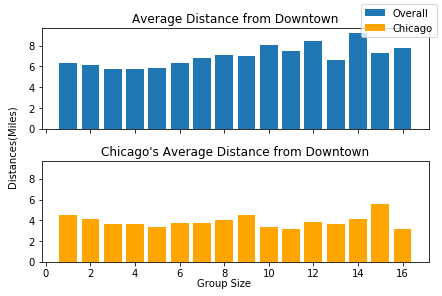

In [37]:
fig, ax = plt.subplots(2,sharey=True,sharex=True)
ax[0].bar(num_people, distances)
ax[0].set_title('Average Distance from Downtown')
ax[1].set_title('Chicago\'s Average Distance from Downtown')
ax[1].bar(num_people, chi_distances, color='orange')
fig.legend(['Overall','Chicago'],loc='upper right')
fig.text(0.5, 0.02, 'Group Size', ha='center', va='center')
fig.text(0.01, 0.5, 'Distances(Miles)',
         ha='center', va='center',
         rotation='vertical')
plt.tight_layout()
plt.savefig('images/distance.png')
plt.show()

In [33]:
chi_prices = [62.85652173913044,
             83.02415812591508,
             111.99675324675324,
             137.48458149779736,
             163.38425925925927,
             209.43304843304844,
             211.11320754716985,
             224.08130081300817,
             287.18181818181824,
             252.46153846153842,
             198.99999999999997,
             303.83333333333326,
             337.0000000000002,
             292.50000000000006,
             0.0,
             481.1111111111108]

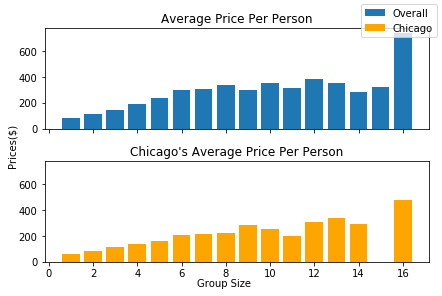

In [34]:
fig, ax = plt.subplots(2,sharey=True,sharex=True)
ax[0].bar(num_people,prices)
ax[0].set_title('Average Price Per Person')
ax[1].bar(num_people,chi_prices, color='orange')
ax[1].set_title('Chicago\'s Average Price Per Person')
fig.legend(['Overall','Chicago'],loc='upper right')
fig.text(0.5, 0.02, 'Group Size', ha='center', va='center')
fig.text(0.01, 0.5, 'Prices($)',
         ha='center', va='center',
         rotation='vertical')
plt.tight_layout()
plt.savefig('images/average_price.png')
plt.show()

In [35]:
chi_probability = [0.06470746832030197,
                   0.3817740630897816,
                   0.08627662442706929,
                   0.19034780264222162,
                   0.06093286600161769,
                   0.11081153949851712,
                   0.0159072526287409,
                   0.04259908331086546,
                   0.004044216770018873,
                   0.022377999460771097,
                   0.0010784578053383662,
                   0.0067403612833647885,
                   0.0018873011593421407,
                   0.0032353734160150984,
                   0.0010784578053383662,
                   0.006201132380695605]

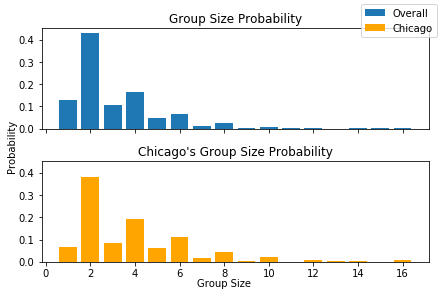

In [36]:
fig, ax = plt.subplots(2,sharey=True,sharex=True)
ax[0].bar(num_people,group_probabilities)
ax[0].set_title('Group Size Probability')
ax[1].bar(num_people, chi_probability, color='orange')
ax[1].set_title('Chicago\'s Group Size Probability')
fig.legend(['Overall','Chicago'],loc='upper right')
fig.text(0.5, 0.02, 'Group Size', ha='center', va='center')
fig.text(0.01, 0.5, 'Probability',
         ha='center', va='center',
         rotation='vertical')
plt.tight_layout()
plt.savefig('images/group_size_p.png')
plt.show();